# Navigation with Categorical DQN Agent

### 1. Initialize Environment, Examine State

In [1]:
import os
import numpy as np
import torch

from collections import deque
from unityagents import UnityEnvironment

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

env = UnityEnvironment(file_name="Banana_Linux/Banana.x86_64", no_graphics=True)

# get the default brain# get t
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

state = env_info.vector_observations[0]  # get the current state
score = 0  # initialize the score

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 2. Instantiate DQN Agent with Prioritized Replay Buffer

In [2]:
# Instantiate Agent
from categorical_dqn.agent import Agent

agent = Agent(state_size=state_size, action_size=action_size, seed=0)

### 3. Train Agent

In [5]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []  # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start  # initialize epsilon
    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        state = torch.from_numpy(state).view(1, -1)
        state = state.type(torch.FloatTensor)

        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]  # get the next state
            next_state = torch.from_numpy(next_state).view(1, -1)
            next_state = next_state.type(torch.FloatTensor)

            reward = env_info.rewards[0]  # get the reward
            done = env_info.local_done[0]  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            # print('\nEpisode {}\t TimeStep {} \tScore: {:.2f} \tDone {}'.format(i_episode, t, score, done), end="")
            if done:
                break
        scores_window.append(score)  # save most recent score
        scores.append(score)  # save most recent score
        eps = max(eps_end, eps_decay * eps)  # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window) >= 13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode - 100,
                                                                                         np.mean(scores_window)))
            torch.save(agent.online_q_net.state_dict(), "checkpoints/categorical_checkpoint.pth")
            break
    return scores

In [6]:
scores = dqn()

/home/slavo/Dev/deep-rl-projects/dqn-navigation/categorical_dqn/agent.py:247: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  next_states = Variable(next_states, volatile=True)


Episode 1	Average Score: 0.00

/home/slavo/Dev/deep-rl-projects/dqn-navigation/categorical_dqn/agent.py:233: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  states = Variable(states, volatile=True)


Episode 100	Average Score: 1.60
Episode 200	Average Score: 5.45
Episode 300	Average Score: 7.26
Episode 400	Average Score: 7.95
Episode 500	Average Score: 10.26
Episode 600	Average Score: 10.69
Episode 700	Average Score: 11.87
Episode 790	Average Score: 13.02
Environment solved in 690 episodes!	Average Score: 13.02


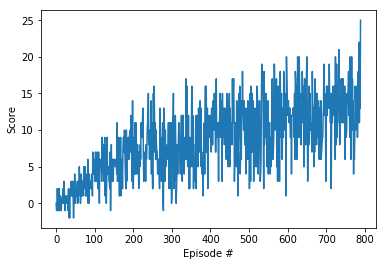

In [8]:
import matplotlib.pyplot as plt

# plot the scores
fig = plt.figure()
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()